# Logistic Regression and Stochastic Gradient Descent


**Name**: Maria Gabriela Ayala

In [454]:
# Import required packages
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
%matplotlib inline

## Logistic Regression + SGD

In this assignment, you'll implement a Logistic Regression classifier to predict whether a reported crime (incident) results in an arrest.  We use the Chicago crime dataset used in Assignment 1, with a few modifications described below.  


Dataset has following attributes:

|Variable|Definition|Key|
|:----:|:----:|:---|
|Hour|Time of incident|integer|
|Domestic|Category of Crime|bool|
|Primary Type |Type of Crime|one hot encoded (all types with moderate arrest rate)|
|Ward	|Location of incident|one hot encoded|
|Arrest	|Whether an arrest was made|bool|




The following cell is a class to load the crime dataset.

In [455]:
class Dataset:
    """
    Class to load dataset containing Chicago crime features
    You shouldn't have to modify this class.
    """

    def __init__(self, location, random_state=1241):
        # Load the dataset
        np.random.seed(random_state)
        small_df = pd.read_csv(location)
        y_crime_df, X_crime_df  = small_df[['Arrest']], small_df.drop(['Arrest'], axis=1)
        self.train_x, self.test_x, self.train_y, self.test_y = train_test_split(
            X_crime_df.to_numpy(), y_crime_df.to_numpy(), test_size=0.2, random_state=123)
        
        # appending biases
        self.train_x = np.concatenate((np.ones((self.train_x.shape[0], 1)), self.train_x), axis=1)
        self.test_x = np.concatenate((np.ones((self.test_x.shape[0], 1)), self.test_x), axis=1)
        

    @staticmethod
    def shuffle(X, y):
        """ Shuffle training data """
        shuffled_indices = np.random.permutation(len(y))
        return X[shuffled_indices], y[shuffled_indices]

### Part 1: Implementing sigmoid

#### Part 1 A 
First, implement the `sigmoid` function to return the output by applying the sigmoid function $\sigma(z)$ to the input parameter, where the sigmoid function $\sigma(z)$ is defined as:
$$
\sigma(z) = \frac{1}{1+e^{-z}}
$$

In [456]:
def sigmoid(score, threshold=20.0):
    """
    Sigmoid function with a threshold
    :param score: (float) A real valued number to convert into a number between 0 and 1
    :param threshold: (float) Prevent overflow of exp by capping activation at 20.
    
    :return: (float) sigmoid function result.
    """
    score = np.clip(score, -threshold, threshold) # Restrict the value of the input score 
    return 1 / (1 + np.exp(-score))

In [457]:
# verify sigmoid implemention w/ scipy;
# note: you should NOT use scipy for your implementation!
from scipy.stats import logistic
assert sigmoid(1) == logistic.cdf(1)
assert sigmoid(5) == logistic.cdf(5)
assert sigmoid(100, threshold=20) == logistic.cdf(20)
assert sigmoid(-1) == logistic.cdf(-1)
assert sigmoid(-5) == logistic.cdf(-5)
assert sigmoid(-100, threshold=20) == logistic.cdf(-20)

#### Part 1 B

Next, implement the derivative of the `sigmoid` function, `sigmoid_grad`, i.e. $\frac{\partial\sigma(x)}{\partial x}$.

Hint: your implementation of `sigmoid_grad` should be able to use  your `sigmoid` function to compute the derivative!

In [458]:
def sigmoid_grad(y, threshold=20.0):
    """
    Derivative/gradient of the sigmoid function.
    :param y: (float) A real valued input for which to compute the derivative.
    :param threshold: (float) Prevent overflow of exp by capping activation at 20.
    
    :return: (float) sigmoid derivative function result.
    """
    
    sigmoid_y = sigmoid(y, threshold)
    return sigmoid_y * (1 - sigmoid_y)

In [459]:
# verify sigmoid_grad using numerical differentiation, i.e: f(x+h)-f(x-h) / 2h
epsilon = 1.0E-8
assert np.isclose(sigmoid_grad(1.0), (sigmoid(1.0 + epsilon) - sigmoid(1.0 - epsilon)) / (2.0*epsilon))
assert np.isclose(sigmoid_grad(0.1), (sigmoid(0.1 + epsilon) - sigmoid(0.1 - epsilon)) / (2.0*epsilon))

### Part 2 

#### Part 2 A 

The negative log likelihood objective is defined as:
$$
\textrm{NLL}(\boldsymbol{\beta}) = -\displaystyle\sum_{i=1}^n \left[y_i \log \sigma(\boldsymbol{\beta}^T{\bf x}^{(i)}) + (1-y_i)\log(1 - \sigma(\boldsymbol{\beta}^T{\bf x}^{(i)}))\right] 
$$

First, write down the derivative of the negative log likelihood objective function, with respect to $\boldsymbol{\beta}$. Since we are working with SGD, derive it for  $n=1$.

 The derivative of the negative log likelihood objective function with respect to $\beta$ is:
 
 $$\frac{\partial(NLL)}{\partial {\beta}} = -(y_i - \sigma_i)x^{(i)}$$ 

Next, using the `sigmoid` function implemented earlier, finish the `sgd_update` function so that it performs stochastic gradient descent on the single training example and updates the weight vector correspondingly without regularization.

In [460]:
class LogReg:
    def __init__(self, num_features, eta):
        """
        Create a logistic regression classifier
        :param num_features: (int) The number of features (including bias)
        :param eta: (float) learning rate
        """
        self.w = np.zeros(num_features)
        self.eta = eta

    def progress(self, examples_x, examples_y):
        """
        Given a set of examples, compute the probability and accuracy
        :param examples_x: (2D np.ndarray) The features from the dataset to score
        :param examples_y: (1D np.ndarray) The labels from the dataset to score

        :return: (float, float) A tuple of (log probability, accuracy)
        """

        logprob = 0.0
        num_right = 0
        for x_i, y in zip(examples_x, examples_y):
            p = sigmoid(self.w.dot(x_i))
            if y == 1:
                logprob += math.log(p)
            else:
                logprob += math.log(1.0 - p)

            # Get accuracy
            if abs(y - p) <= 0.5:
                num_right += 1

        return logprob, float(num_right) / float(len(examples_y))

    def sgd_update(self, x_i, y, lam=0.0):
        """
        Compute a stochastic gradient update to improve the log likelihood.
        :param x_i: (1D np.ndarray) The features of the example to take the gradient with respect to
        :param y: (float) The target output of the example to take the gradient with respect to
        :param lam: (float) regularization term. Default is zero; only used in Part 2D. 
        :return: (1D np.ndarray) Return the new value of the regression coefficients
        """
        pi = sigmoid(np.dot(self.w, x_i))
        self.w[0] = self.w[0] - self.eta * (0.0 * self.w[0]- x_i[0] * (y - pi))
        self.w[1:] = self.w[1:] - self.eta * (lam*2 * self.w[1:] - x_i[1:] * (y - pi))

        return self.w
    

In [461]:
from tests import tests
tests.run_test_suite('prob 2A', LogReg)

testPosUnregUpdate (tests.tests.TestLogReg)
test update based on positive example ... ok
testNegUnregUpdate (tests.tests.TestLogReg)
test update based on negative example ... ok

----------------------------------------------------------------------
Ran 2 tests in 0.007s

OK


#### Part 2 B 
Complete the code below to loop over the training data and perform stochastic gradient descent for a pre-defined number of epochs. You do not need to use the parameters lam and decay for this part.

Note: remember to shuffle your training data using `Dataset.shuffle` at the beginning of each epoch.

In [484]:
def train(epochs, eta, store_epoch, lam=0, decay=0.001):
    """
    Train a LogReg object for a set number of epochs with a given eta.
    
    :param epochs: (int) total number of training epochs
    :param eta: (float) learning rate
    :param store_epoch: (int) store training and test accuracies every store_epoch epochs
    :param lam: (float) weight given to regularization term. Default 0. Only used in Part 2D. 
    :param decay: (float) Used to update learning rate during training (Part 3). 
                  Equals 0 when learning rate is constant throughout training (Part 2). 
                  
    :return (train_accuracy_array, test_accuracy_array, learning_rates): tuple of (List, List, List)
        :train_accuracy_array: training accuracy after every store_epoch epochs
        :test_accuracy_array: test accuracy after every store_epoch epochs
        :learning_rates: learning rate after every store_epoch epochs. All values in this list 
                         will be the same if decay = 0 (Only required for Part 2F)
    
        Example: With epochs = 30 and store_epoch = 10, only store accuracies after epochs = 10, 20, and 30.
    """
    
    dataset_handler = Dataset('data/crime.csv')
    lr = LogReg(dataset_handler.train_x.shape[1], eta)

    assert dataset_handler.train_x.shape == (1105, 60) 
    assert dataset_handler.test_x.shape == (277, 60) 
    
    train_accuracy_array = []
    test_accuracy_array = []
    learning_rates = []
    for epoch in range(epochs):
        x_train, y_train = dataset_handler.shuffle(dataset_handler.train_x, dataset_handler.train_y) 
        for x_i, y in zip(x_train, y_train):
            lr.sgd_update(x_i, y, lam)

        _, accuracy_train = lr.progress(x_train, y_train)
        _, accuracy_test = lr.progress(dataset_handler.test_x, dataset_handler.test_y)
            
        lr.eta = lr.eta/(1 + decay * epoch)
        if (epoch + 1) % store_epoch == 0:
            train_accuracy_array.append(accuracy_train)
            test_accuracy_array.append(accuracy_test)
            learning_rates.append(lr.eta)


    return train_accuracy_array, test_accuracy_array, learning_rates

In [475]:
eta  = 1e-4
epochs = 300
store_epoch = 50
train_acc, test_acc, _ = train(epochs, eta, store_epoch)

for i in range(len(train_acc)):
    print("\ntrain accuracy after {} epochs: {}".format((i+1)*store_epoch, train_acc[i]))
    print("test accuracy after {} epochs: {}".format((i+1)*store_epoch, test_acc[i]))



train accuracy after 50 epochs: 0.6298642533936651
test accuracy after 50 epochs: 0.592057761732852

train accuracy after 100 epochs: 0.63710407239819
test accuracy after 100 epochs: 0.5884476534296029

train accuracy after 150 epochs: 0.6524886877828054
test accuracy after 150 epochs: 0.6064981949458483

train accuracy after 200 epochs: 0.6678733031674208
test accuracy after 200 epochs: 0.6137184115523465

train accuracy after 250 epochs: 0.6742081447963801
test accuracy after 250 epochs: 0.6209386281588448

train accuracy after 300 epochs: 0.685972850678733
test accuracy after 300 epochs: 0.628158844765343


#### Part 2 C
What is the role of the learning rate? What are the pros and cons of high/low learning rates? Do you see any trade-off? First, plot accuracies of different $\eta$'s together vs. number of epochs for both training and testing. Then briefly elaborate on these questions.

In [476]:
dataset_handler = Dataset('data/crime.csv')
train_results = {}
test_results = {}

epochs = 400
store_epoch = 10
for eta in [1e-3, 1e-4, 1e-5, 1e-6]:
    
    train_accuracy_array, test_accuracy_array, _ = train(epochs, eta, store_epoch)
    train_results[eta] = train_accuracy_array
    test_results[eta] = test_accuracy_array

Plot training results below.

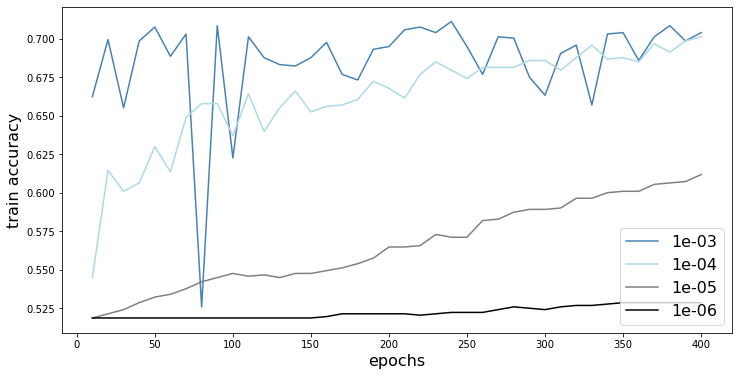

In [477]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12,6))
epochs_array = [i for i in range(store_epoch, epochs, store_epoch)]
epochs_array.append(epochs)
ax.plot(epochs_array, train_results[1e-3], color="steelblue", label='1e-03')
ax.plot(epochs_array, train_results[1e-4], color="lightblue", label='1e-04')
ax.plot(epochs_array, train_results[1e-5], color="grey", label='1e-05')
ax.plot(epochs_array, train_results[1e-6], color="black", label='1e-06')
ax.legend(loc="lower right", fontsize=16)
ax.set_xlabel("epochs", fontsize=16)
ax.set_ylabel("train accuracy", fontsize=16)
plt.show()

Plot testing results below.

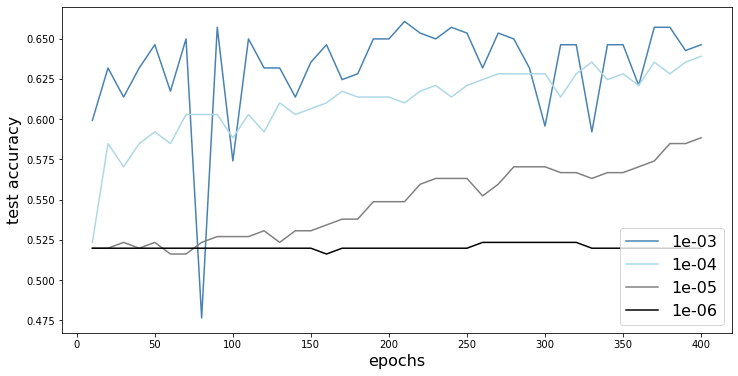

In [478]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12,6))
epochs_array = [i for i in range(store_epoch,epochs,store_epoch)]
epochs_array.append(epochs)
ax.plot(epochs_array, test_results[1e-3], color="steelblue", label='1e-03')
ax.plot(epochs_array, test_results[1e-4], color="lightblue", label='1e-04')
ax.plot(epochs_array, test_results[1e-5], color="grey", label='1e-05')
ax.plot(epochs_array, test_results[1e-6], color="black", label='1e-06')
ax.legend(loc="lower right", fontsize=16)
ax.set_xlabel("epochs", fontsize=16)
ax.set_ylabel("test accuracy", fontsize=16)
plt.show()

From the graphs, we can observe that when setting a very low learning rate (ie. $\eta$ = 1e-06), the accuracy of the algorithm is low (both in the test and train data) and the improvements are linear, however, the performance of the algorithm is stable. That is to say, there are no drastic spikes or inconsistencies in accuracy from one epoch to another.

On the other hand, when the learning rate is high (ie. $\eta$ = 1e-03), the Logistic Regression algorithm tends to have a higher level of accuracy overall (compared to a very low learning rate), and is more exponential in nature. However, it is very inconsistent in terms of accuracy in between epochs, unable to settle down. We observe very marked increases and decreases in accuracy, showing that the prediction is not stable and, in between epochs 50 - 100, accuracy is extremly off. This instability in performance is more pronounced in the testing data scenario.

Therefore, there is a clear trade-off between bias and variance when choosing high vs. low learning rates. For example, the learning rate set at $\eta$ = 1e-04, has an increasing trend in accuracy as the number of epochs increase and its performance is more stable/less variance than with $\eta$ = 1e-03.

#### Part 2 D 

Adding $l_2$ regularization to the feature parameters for NLL loss gives:

$$
\textrm{NLL}_{l_2}(\boldsymbol{\beta}) = -\displaystyle\sum_{i=1}^n \left[y_i \log \sigma(\boldsymbol{\beta}^T{\bf x}^{(i)}) + (1-y_i)\log(1 - \sigma(\boldsymbol{\beta}^T{\bf x}^{(i)}))\right] + \lambda\displaystyle\sum_{k=1}^{p} \beta_{k}^2
$$

where $p$ is the number of features, and $\beta_0$ is the bias term. Notice that $\beta_0$ is not included in the regularization term.

Write down the derivative of the regularized negative log likelihood loss function $\textrm{NLL}_{l_2}$ with respect to $\boldsymbol{\beta}$. Since we are working with SGD, derive it for $n=1$.

 The derivative of the negative log likelihood objective function with respect to $\beta$ is:
 
 $$\frac{\partial(NLL_{l2})}{\partial {\beta}} = -(y_i - \sigma_i)x^{(i)} + 2\lambda  \beta_k$$ 

Update your implementation of the `sgd_update` method so that it performs regularized SGD updates of the model parameters to minimize the regularized NLL loss function.

Remember, do **not** regularize the bias parameter $\beta_0$.

Provide train and test accuracy after above change with `lam=1e-5`.

In [479]:
from tests import tests
tests.run_test_suite('prob 2E', LogReg)

testNegRegUpdate (tests.tests.TestLogReg)
test update based on negative example ... ok
testPosRegUpdate (tests.tests.TestLogReg)
test regularized update based on positive example ... ok

----------------------------------------------------------------------
Ran 2 tests in 0.003s

OK


The following code chunck shows train and test accuracies after including regularization and setting lambda to `lam=1e-5`:

In [480]:
lam = 1e-5
eta  = 1e-4
epochs = 300
store_epoch = 50
train_acc, test_acc, _ = train(epochs, eta, store_epoch, lam)

for i in range(len(train_acc)):
    print("\ntrain accuracy after {} epochs: {}".format((i+1)*store_epoch, train_acc[i]))
    print("test accuracy after {} epochs: {}".format((i+1)*store_epoch, test_acc[i]))


train accuracy after 50 epochs: 0.6298642533936651
test accuracy after 50 epochs: 0.592057761732852

train accuracy after 100 epochs: 0.63710407239819
test accuracy after 100 epochs: 0.5884476534296029

train accuracy after 150 epochs: 0.6524886877828054
test accuracy after 150 epochs: 0.6064981949458483

train accuracy after 200 epochs: 0.6678733031674208
test accuracy after 200 epochs: 0.6137184115523465

train accuracy after 250 epochs: 0.6742081447963801
test accuracy after 250 epochs: 0.6209386281588448

train accuracy after 300 epochs: 0.685972850678733
test accuracy after 300 epochs: 0.628158844765343


#### Part 2 E
Update your implementation of train() to incorporate a regularization term. The change should typically be on only one line in your code.

Plot accuracies of different $\lambda$'s together vs. epochs for both training and testing).

In [481]:
dataset_handler = Dataset('data/crime.csv')
train_results = {}
test_results = {}
epochs = 400
store_epoch = 10
eta = 1e-4
for lam in [0, 0.1, 0.05, 0.01]:
    train_accuracy_array, test_accuracy_array, _ = train(epochs, eta, store_epoch, lam)
    train_results[lam] = train_accuracy_array
    test_results[lam] = test_accuracy_array

Plot training results below.

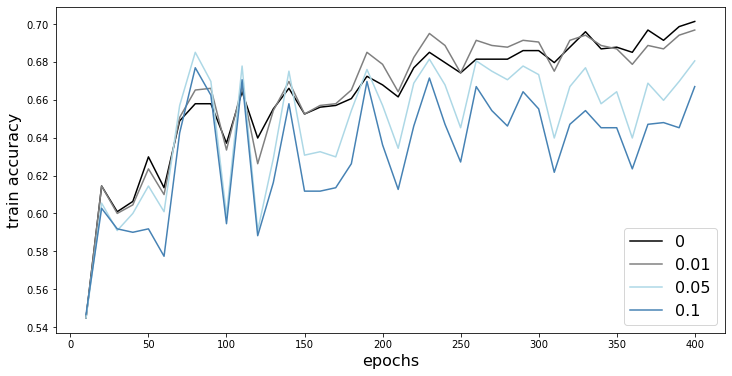

In [482]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12,6))
epochs_array = [i for i in range(store_epoch,epochs,store_epoch)]
epochs_array.append(epochs)
ax.plot(epochs_array, train_results[0], color="black", label=str(0))
ax.plot(epochs_array, train_results[0.01], color="grey", label=str(0.01))
ax.plot(epochs_array, train_results[0.05], color="lightblue", label=str(0.05))
ax.plot(epochs_array, train_results[0.1], color="steelblue", label=str(0.1))
ax.legend(loc="lower right", fontsize=16)
ax.set_xlabel("epochs", fontsize=16)
ax.set_ylabel("train accuracy", fontsize=16)
plt.show()

Plot testing results below.

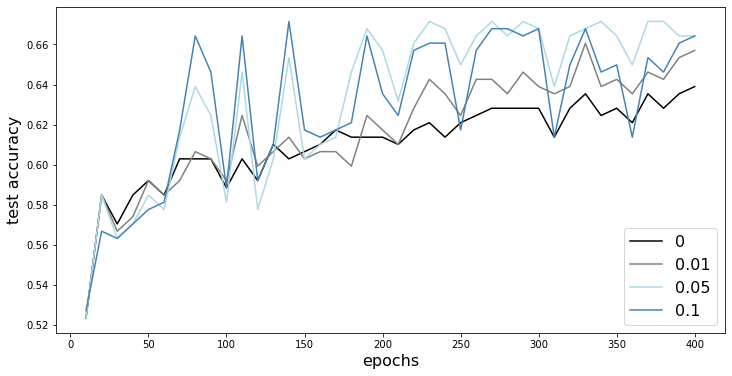

In [483]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12,6))
epochs_array = [i for i in range(store_epoch,epochs,store_epoch)]
epochs_array.append(epochs)
ax.plot(epochs_array, test_results[0], color="black", label=str(0))
ax.plot(epochs_array, test_results[0.01], color="grey", label=str(0.01))
ax.plot(epochs_array, test_results[0.05], color="lightblue", label=str(0.05))
ax.plot(epochs_array, test_results[0.1], color="steelblue", label=str(0.1))
ax.legend(loc="lower right", fontsize=16)
ax.set_xlabel("epochs", fontsize=16)
ax.set_ylabel("test accuracy", fontsize=16)
plt.show()

### Part 2 F
What is the effect of regularization term with respect to accuracy? 

From the graphs we can observe that increasing the regularization term results in better generalization in the unseen testing data, than in the training data. For example, by setting the regularization term on the higher end, ie. $\lambda$ = 0.1 or 0.05, the overall accuracy of the algorithm is much higher in the testing data than in the training data. Therefore, the regularization term is preventing overfitting by allowing more training error in exchange of a lower generalization error in unseen data, which is ultimately the goal of machine learning.

On the other hand, a lowe regularization term $\lambda$ = 0.01 or no regularization, does not penalize overfitting such that the algorithm is more accurate in the tranining data at the expense of losing accuracy in the testing/validation data.

### Part 3

Time based Learning Rate is dynamic learning rate given the following equation:

$\textrm{LearningRate} = \eta\, / \,(1 + \textrm{decay} \cdot \textrm{current epoch})$

Train SGD with the dynamic learning rate defined above and follow these instructions:
* Use initial learning rate $\eta = 0.1$.
* Use $\textrm{decay} = 0.001$.
* Update learning rate `lr.eta` every epoch.
* Use $\lambda = 0$ (no regularization)
* Plot train accuracy and learning rate together for each epoch.

The above can be accomplished by changing one line in `train()` from Part 2a. 

In [485]:
eta  = 1e-1
epochs = 200
store_epoch = 1

train_accuracy_array, _, learning_rates = train(epochs, eta, store_epoch)


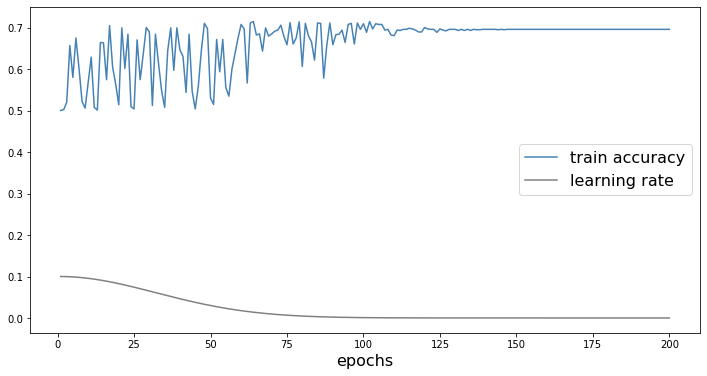

In [486]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12,6))
epochs_array = [i for i in range(1,epochs)]
epochs_array.append(epochs)
ax.plot(epochs_array, train_accuracy_array, color="steelblue", label=str('train accuracy'))
ax.plot(epochs_array, learning_rates,color="grey", label=str('learning rate'))
ax.legend(loc="center right", fontsize=16)
ax.set_xlabel("epochs", fontsize=16)
ax.set_ylabel("", fontsize=16)
plt.show()

After a certain number of epochs, the accuracy for the train algorithm becoms steady such that dynamic changes in the learning rate eventually have a marginal effect on accuracy, compared to the initial adjustments in the dynamic learning rate which have big effects on accuracy up until the algorithm converges.